In [2]:
%matplotlib inline
import pathlib
from glob import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
def read_time_series(path):
    df = pd.read_csv(path)
    df.index = df.time
    df = df[['area']]
    
    return df

In [4]:
dir_data = '../data/reservoir-time-series-2021-Q3'

out_dir_monthly_timeseries_by_country = pathlib.Path(f'{dir_data}/time_series_area_by_country/')
out_dir_monthly_timeseries_by_country.mkdir(exist_ok=True)

out_dir_monthly_timeseries_by_basin = pathlib.Path(f'{dir_data}/time_series_area_by_basin/')
out_dir_monthly_timeseries_by_basin.mkdir(exist_ok=True)

In [5]:
dir_monthly_timeseries = f'{dir_data}/time_series_area_monthly/'

In [6]:
reservoirs_and_country_basin = gpd.read_file(f'{dir_data}/../shp/extra/reservoirs-v1.0-and-countries-basins.shp')

In [7]:
reservoirs_and_country_basin.fillna(value=-9999, inplace=True)
reservoirs_and_country_basin = reservoirs_and_country_basin[reservoirs_and_country_basin.basin_id != -9999]

In [8]:
reservoirs_and_country_basin.fid = reservoirs_and_country_basin.fid.astype(int)
reservoirs_and_country_basin.basin_id = reservoirs_and_country_basin.basin_id.astype(int)

In [9]:
reservoirs_and_country_basin

,fid,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter,basin_id,basin_name,country_co,country_na,geometry
0,2192,1.166049e+04,7.912045e+03,6331.904538,7.478652e+03,0.543022,0.641367,6016,"Caspian Sea, East Coast",AF,Afghanistan,POINT (60.99597 34.27504)
1,80316,2.024863e+06,1.638018e+06,329582.824251,1.043686e+06,0.162768,0.515435,6016,"Caspian Sea, East Coast",AF,Afghanistan,POINT (63.82601 34.33009)
2,577,8.046256e+03,7.181635e+03,1496.385538,2.363427e+03,0.185973,0.293730,7017,"Africa, Indian Ocean Coast",ZI,Zimbabwe,POINT (30.04074 -19.95877)
3,1657,1.675097e+04,1.664923e+04,1452.810236,1.726649e+03,0.086730,0.103078,7017,"Africa, Indian Ocean Coast",ZI,Zimbabwe,POINT (31.23083 -20.26491)
4,2787,1.807379e+04,1.692719e+04,5713.635387,2.054337e+03,0.316128,0.113664,7017,"Africa, Indian Ocean Coast",ZI,Zimbabwe,POINT (30.35264 -20.81181)
...,...,...,...,...,...,...,...,...,...,...,...,...
71045,75285,1.648303e+06,1.668095e+06,106335.024089,1.630787e+05,0.064512,0.098937,5022,Salween,CH,China,POINT (99.20958 25.24949)
71046,76108,1.326794e+06,1.324459e+06,119896.146974,1.865901e+05,0.090365,0.140632,5022,Salween,CH,China,POINT (99.20742 24.65804)
71047,78432,3.184542e+06,3.204209e+06,135304.241515,2.293301e+05,0.042488,0.072014,5022,Salween,CH,China,POINT (96.56137 30.67137)
71048,80032,2.054757e+06,2.004311e+06,588557.348674,9.138568e+05,0.286436,0.444752,5022,Salween,CH,China,POINT (98.81432 24.52365)


In [10]:
reservoirs_and_country_basin[['fid', 'country_na', 'country_co', 'basin_name', 'basin_id']]

,fid,country_na,country_co,basin_name,basin_id
0,2192,Afghanistan,AF,"Caspian Sea, East Coast",6016
1,80316,Afghanistan,AF,"Caspian Sea, East Coast",6016
2,577,Zimbabwe,ZI,"Africa, Indian Ocean Coast",7017
3,1657,Zimbabwe,ZI,"Africa, Indian Ocean Coast",7017
4,2787,Zimbabwe,ZI,"Africa, Indian Ocean Coast",7017
...,...,...,...,...,...
71045,75285,China,CH,Salween,5022
71046,76108,China,CH,Salween,5022
71047,78432,China,CH,Salween,5022
71048,80032,China,CH,Salween,5022


Text(0.5, 0, '$Surface\\ water\\ area, m^2$')

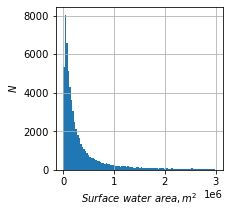

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))
reservoirs_and_country_basin[reservoirs_and_country_basin['median'] < 3000000]['median'].hist(bins=100, ax=ax)
ax.set_ylabel('$N$')
ax.set_xlabel('$Surface\ water\ area, m^2$')

In [12]:
# set filter on reservoir size if needed!
# reservoirs_and_country_basin = reservoirs_and_country_basin[reservoirs_and_country_basin.mean < MAX_RESERVOIR_SIZE]


In [13]:
def merge_time_series(filenames):
    df = None

    for i, f in enumerate(filenames):
        path = pathlib.Path(dir_monthly_timeseries) / f

        if not path.exists():
            print(f'Warning, time series does not exist: {path.name}')
            continue

        df_ = read_time_series(path)
        if df is None:
            df = df_
        else:
            df = df.join(df_, how='outer', rsuffix=f'_{i}')

            df['area'] = df.sum(axis=1)
            df = df[['area']]

    if df is None:
        df = pd.DataFrame({'time': [], 'area': []})
        df = df.set_index('time')

    return df

In [14]:
def compute_aggreated_timeseries_country(country_code):
    reservoir_ids = reservoirs_and_country_basin[reservoirs_and_country_basin.country_co == country_code].fid.values    
    filenames = [f'{str(fid).zfill(7)}.csv' for fid in reservoir_ids]

    df = merge_time_series(filenames)
        
    df.to_csv(out_dir_monthly_timeseries_by_country / f'{country_code}.csv')
    
    return df

In [15]:
def compute_aggreated_timeseries_basin(basin_id):
    reservoir_ids = reservoirs_and_country_basin[reservoirs_and_country_basin.basin_id == basin_id].fid.values    
    filenames = [f'{str(fid).zfill(7)}.csv' for fid in reservoir_ids]

    df = merge_time_series(filenames)

    df.to_csv(out_dir_monthly_timeseries_by_basin / f'{basin_id}.csv')
    
    return df


In [16]:
country_codes = reservoirs_and_country_basin.country_co.unique()
for i in tqdm(country_codes):
    compute_aggreated_timeseries_country(i)

  0%|          | 0/186 [00:00<?, ?it/s]

In [17]:
basin_ids = reservoirs_and_country_basin.basin_id.unique()
for i in tqdm(basin_ids):
    compute_aggreated_timeseries_basin(i)

  0%|          | 0/220 [00:00<?, ?it/s]

In [ ]:
# THE END OF UPDATE CODE


In [16]:
reservoirs_and_country_basin[reservoirs_and_country_basin.country_na.str.contains("South Africa")]

,fid,mean,median,sd_intra,sd_inter,rsd_intra,rsd_inter,basin_id,basin_name,country_co,country_na,geometry
13364,34,3.111217e+03,2.889558e+03,5.825452e+02,9.875439e+02,0.187240,0.317414,7008,Orange,SF,South Africa,POINT (29.34796 -26.75578)
13365,360,1.374545e+04,1.393111e+04,1.224819e+03,1.892791e+03,0.089107,0.137703,7008,Orange,SF,South Africa,POINT (26.94838 -27.21931)
13366,445,5.701789e+03,5.817089e+03,1.243052e+03,1.396330e+03,0.218011,0.244893,7008,Orange,SF,South Africa,POINT (26.21392 -29.05188)
13367,573,5.104471e+03,4.811818e+03,1.074480e+03,1.228002e+03,0.210498,0.240574,7008,Orange,SF,South Africa,POINT (28.15069 -28.71267)
13368,617,7.072984e+03,7.716490e+03,1.507361e+03,1.962798e+03,0.213115,0.277506,7008,Orange,SF,South Africa,POINT (27.23512 -30.71987)
...,...,...,...,...,...,...,...,...,...,...,...,...
57404,85903,1.705037e+07,1.806845e+07,5.881152e+05,1.969180e+06,0.034493,0.115492,7007,Limpopo,SF,South Africa,POINT (27.86679 -25.75006)
57405,85931,1.232032e+07,1.197507e+07,7.222125e+05,4.508554e+06,0.058620,0.365944,7007,Limpopo,SF,South Africa,POINT (29.43036 -24.79704)
57406,86753,2.083620e+07,2.242776e+07,1.008706e+06,2.913295e+06,0.048411,0.139819,7007,Limpopo,SF,South Africa,POINT (29.31560 -25.43119)
57407,86960,1.663895e+07,1.558422e+07,1.355263e+06,6.659143e+06,0.081451,0.400214,7007,Limpopo,SF,South Africa,POINT (26.45359 -24.89327)


In [17]:
compute_aggreated_timeseries_country('SF')

In [72]:
reservoir_ids = reservoirs_and_country_basin[reservoirs_and_country_basin.country_co == 'SF'].fid.values
reservoir_ids

array([   34,   360,   445, ..., 86753, 86960, 87166])

In [74]:
filenames = [f'{str(fid).zfill(7)}.csv' for fid in reservoir_ids]
filenames[:10]

['0000034.csv',
 '0000360.csv',
 '0000445.csv',
 '0000573.csv',
 '0000617.csv',
 '0000626.csv',
 '0000628.csv',
 '0000670.csv',
 '0001013.csv',
 '0001098.csv']

In [75]:
dfs = []
for f in filenames:
    path = pathlib.Path(dir_monthly_timeseries) / f
    dfs.append(read_time_series(path))

In [76]:
df = dfs[0]
for i, df_ in tqdm(enumerate(dfs[1:]), total=len(dfs)-1):
    df = df.join(df_, how='outer', rsuffix=f'_{i}')

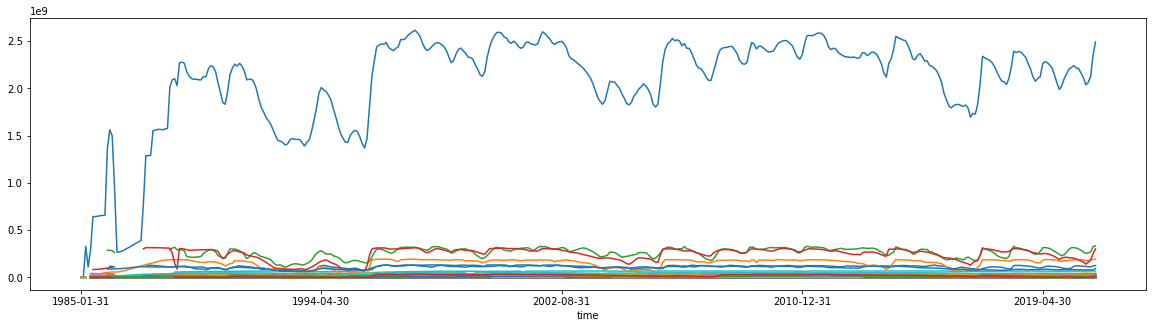

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
df.sum(axis=1).plot(ax=ax, legend=False)
df.plot(ax=ax, legend=False)

In [17]:
df

,area,area_0,area_1
time,,,
1985-04-30,239163.483881,43776.246536,363793.896198
1985-05-31,248218.860104,44971.748637,352711.762373
1985-06-30,255326.369890,48179.330350,347178.165959
1985-07-31,260991.850232,53260.756086,345042.627438
1985-08-31,264983.388068,59780.226353,344737.550506
...,...,...,...
2020-10-31,217268.325283,364691.153310,263158.695798
2020-11-30,268902.106534,392880.723762,306353.924487
2020-12-31,255318.432055,397383.018232,313321.056827


In [72]:
def export_for_area(area_id):
    
    reservoir_ids = reservoirs_and_gadm2[reservoirs_and_gadm2.GID_2 == area_id].fid.values
    
    


In [12]:
export_for_area('AFG.11.4_1')

In [2]:
files = glob('../data/time_series_monthly_aggregated_v2/reservoirs_area_by_country_and_basin_*.csv')

In [3]:
files

['../data/time_series_monthly_aggregated_v2\\reservoirs_area_by_country_and_basin_00000_00010_v2.csv',
 '../data/time_series_monthly_aggregated_v2\\reservoirs_area_by_country_and_basin_00010_00025_v2.csv',
 '../data/time_series_monthly_aggregated_v2\\reservoirs_area_by_country_and_basin_00025_00050_v2.csv',
 '../data/time_series_monthly_aggregated_v2\\reservoirs_area_by_country_and_basin_00050_00100_v2.csv',
 '../data/time_series_monthly_aggregated_v2\\reservoirs_area_by_country_and_basin_00100_00250_v2.csv',
 '../data/time_series_monthly_aggregated_v2\\reservoirs_area_by_country_and_basin_00250_00500_v2.csv',
 '../data/time_series_monthly_aggregated_v2\\reservoirs_area_by_country_and_basin_00500_05000_v2.csv',
 '../data/time_series_monthly_aggregated_v2\\reservoirs_area_by_country_and_basin_05000_500000_v2.csv']

In [4]:
df_new=None
for i, file in enumerate(files):
    size = int(file[-13:-7].strip('_'))

    df_new = pd.read_csv(file)

    print(len(df_new.index), size)

    df_new['reservoir_area_max'] = size

    if i == 0:
        df = df_new
    else:
        df = pd.concat([df, df_new])

110794 10
159432 25
168770 50
171485 100
159001 250
136829 500
148898 5000
109725 500000


In [5]:
df.columns

Index(['system:index', 'Area', 'MAJ_BAS', 'MAJ_NAME', 'OBJECTID', 'Shape_Area',
       'Shape_Leng', 'abbreviati', 'area_reservoirs', 'country_co',
       'country_na', 'reservoir_count', 'time', 'wld_rgn', '.geo',
       'reservoir_area_max'],
      dtype='object')

In [6]:
new_names = {
    'Area': 'basin_area',
    'MAJ_BAS': 'basin_id',
    'MAJ_NAME': 'basin_name',
    'abbreviati': 'country_abbr',
    'country_co': 'country_code',
    'country_na': 'country_name',
    'wld_rgn': 'world_region',
    'area_reservoirs': 'reservoir_area'
}

df = df.rename(columns=new_names)

In [7]:
df = df.astype({'basin_id': 'int32'})

In [8]:
df.columns

Index(['system:index', 'basin_area', 'basin_id', 'basin_name', 'OBJECTID',
       'Shape_Area', 'Shape_Leng', 'country_abbr', 'reservoir_area',
       'country_code', 'country_name', 'reservoir_count', 'time',
       'world_region', '.geo', 'reservoir_area_max'],
      dtype='object')

In [9]:
df = df[['basin_id', 'basin_name',
         'country_code', 'country_abbr', 'country_name', 
         'reservoir_count', 'reservoir_area', 'time', 'reservoir_area_max']]

In [10]:
df = df[['basin_id', 'country_code', 'reservoir_area_max', 'time', 'reservoir_area']]

In [11]:
df.head()

,basin_id,country_code,reservoir_area_max,time,reservoir_area
0,1001,US,10,475977600000,1.792877e+05
1,1001,US,10,478396800000,1.715190e+05
2,1001,US,10,481075200000,3.888981e+05
3,1001,US,10,483667200000,1.092151e+06
4,1001,US,10,486345600000,1.127930e+06


In [12]:
df.country_code.unique()

array(['US', 'CA', 'MX', 'GT', 'BH', 'NU', 'CU', 'HA', 'CO', 'VE', 'BL',
       'EC', 'PE', 'BR', 'UY', 'PA', 'AR', 'CI', 'PO', 'SP', 'FR', 'SZ',
       'UK', 'IM', 'EI', 'NL', 'GM', 'IT', 'RO', 'HR', 'RI', 'BU', 'EZ',
       'LO', 'HU', 'SI', 'AU', 'SW', 'BO', 'PL', 'AL', 'GR', 'MK', 'TU',
       'RS', 'UP', 'LH', 'LG', 'KZ', 'EN', 'NO', 'IC', 'CH', 'HK', 'KS',
       'KN', 'VM', 'TH', 'LA', 'CB', 'MY', 'BM', 'ID', 'TW', 'RP', 'IN',
       'PK', 'AF', 'CE', 'JA', 'CY', 'IS', 'IR', 'AJ', 'AM', 'GG', 'IZ',
       'SY', 'JO', 'SA', 'UZ', 'MR', 'GV', 'NI', 'RW', 'ER', 'ET', 'KE',
       'UG', 'TZ', 'BY', 'CF', 'CG', 'MI', 'ZA', 'ZI', 'AO', 'BC', 'SF',
       'LT', 'CD', 'CM', 'WA', 'TS', 'MO', 'AG', 'IV', 'SG', 'WI', 'UV',
       'TO', 'GH', 'AS', 'NZ', 'PM', 'CS', 'RQ', 'GP', 'DR', 'JM', 'FG',
       'AN', 'JE', 'GK', 'BE', 'LU', 'MD', 'BK', 'MJ', 'FI', 'MG', 'BG',
       'NP', 'AX', 'GZ', 'WE', 'NM', 'LE', 'YM', 'MU', 'AE', 'TX', 'TI',
       'KG', 'NG', 'BN', 'SU', 'EG', 'OD', 'SO', 'M

In [13]:
df.basin_id.unique()

array([1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1014, 1016, 1017, 1018, 2001, 2002, 2003, 2004, 2007, 2008, 2009,
       2013, 2014, 2015, 3002, 3003, 3005, 3006, 3008, 3009, 3010, 3011,
       3012, 3014, 3018, 3019, 3020, 3021, 3022, 3023, 4001, 4002, 4003,
       4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014,
       4015, 4016, 4017, 4018, 4020, 4021, 4022, 4023, 4024, 4025, 4026,
       4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4039,
       4042, 4043, 4044, 4045, 4046, 4047, 4051, 4052, 5001, 5002, 5004,
       5005, 5006, 5009, 5010, 5011, 5012, 5014, 5016, 5017, 5018, 5019,
       5020, 5021, 5022, 5024, 5026, 5027, 5028, 5030, 5034, 5035, 5036,
       5037, 5038, 5039, 5040, 5041, 5042, 5043, 5044, 5045, 5046, 5047,
       5048, 5049, 5050, 5051, 5052, 5056, 5065, 5067, 5068, 6001, 6002,
       6003, 6004, 6005, 6006, 6009, 6010, 6011, 6012, 6016, 6017, 6018,
       7001, 7002, 7003, 7005, 7006, 7007, 7008, 70

In [14]:
df = df.round({'reservoir_area': 0})

In [15]:
df = df.astype({'reservoir_area': 'int64'})

In [16]:
df.time = pd.to_datetime(df.time, unit='ms')

In [61]:
df.to_csv('../data/time_series_monthly_aggregated_v2/reservoir_area_monthly_by_country_size_and_basin.csv', index=False)

In [21]:
# save by country
for c in df.country_code.unique():
    print(c)
    df_country = df[df.country_code == c]
    columns = ['basin_id', 'reservoir_area_max', 'time', 'reservoir_area']
    df_country[columns].to_csv('../data/time_series_aggregated/time-series-aggregated-with-size/by_country/' + c + '.csv', index=False)


US
CA
MX
GT
BH
NU
CU
HA
CO
VE
BL
EC
PE
BR
UY
PA
AR
CI
PO
SP
FR
SZ
UK
IM
EI
NL
GM
IT
RO
HR
RI
BU
EZ
LO
HU
SI
AU
SW
BO
PL
AL
GR
MK
TU
RS
UP
LH
LG
KZ
EN
NO
IC
CH
HK
KS
KN
VM
TH
LA
CB
MY
BM
ID
TW
RP
IN
PK
AF
CE
JA
CY
IS
IR
AJ
AM
GG
IZ
SY
JO
SA
UZ
MR
GV
NI
RW
ER
ET
KE
UG
TZ
BY
CF
CG
MI
ZA
ZI
AO
BC
SF
LT
CD
CM
WA
TS
MO
AG
IV
SG
WI
UV
TO
GH
AS
NZ
PM
CS
RQ
GP
DR
JM
FG
AN
JE
GK
BE
LU
MD
BK
MJ
FI
MG
BG
NP
AX
GZ
WE
NM
LE
YM
MU
AE
TX
TI
KG
NG
BN
SU
EG
OD
SO
MA
WZ
MZ
GB
BF
AC
CJ
ST
KV
DA
UU
SN
BT
ML
LY
MF
SL
LI
HO
RN
TD
NS
GL
MC
BX
BP
DX
FJ
VQ
MB
GQ
NC
ES
NN
QA
EK
PP
CT


In [24]:
# save by basin
for b in df.basin_id.unique():
    df_basin = df[df.basin_id == b]
    columns = ['country_code', 'reservoir_area_max', 'time', 'reservoir_area']
    df_basin[columns].to_csv('../data/time_series_aggregated/time-series-aggregated-with-size/by_basin/' + str(b) + '.csv', index=False)


1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1014
1016
1017
1018
2001
2002
2003
2004
2007
2008
2009
2013
2014
2015
3002
3003
3005
3006
3008
3009
3010
3011
3012
3014
3018
3019
3020
3021
3022
3023
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4020
4021
4022
4023
4024
4025
4026
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4039
4042
4043
4044
4045
4046
4047
4051
4052
5001
5002
5004
5005
5006
5009
5010
5011
5012
5014
5016
5017
5018
5019
5020
5021
5022
5024
5026
5027
5028
5030
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5056
5065
5067
5068
6001
6002
6003
6004
6005
6006
6009
6010
6011
6012
6016
6017
6018
7001
7002
7003
7005
7006
7007
7008
7009
7010
7011
7014
7016
7017
7018
7019
7020
7021
7023
7024
7025
7026
7027
8001
8002
8003
8004
8005
8006
8008
8009
3016
1013
2006
2010
2011
2012
3001
3004
3007
3013
3024
3025
4019
4027
4038
4040
4048
4049
5003
5007
5023
5025
5031
5032
5063
5064
5066


In [31]:
# save by basin and country
for b in df.basin_id.unique():
    for c in df.country_code.unique():
        df_area = df[df.country_code == c]
        df_area = df_area[df_area.basin_id == b]
        if len(df_area) > 0:
            print(c + '_' + str(b))
            columns = ['reservoir_area_max', 'time', 'reservoir_area']
            df_area[columns].to_csv('../data/time_series_aggregated/time-series-aggregated-with-size/by_country_basin/' + c + '_' + str(b) + '.csv', index=False)


US_1001
US_1002
US_1003
CA_1003
US_1004
US_1005
MX_1005
US_1006
US_1007
MX_1007
US_1008
CA_1008
CA_1009
US_1010
CA_1010
US_1011
CA_1011
US_1014
CA_1014
US_1016
CA_1016
US_1017
CA_1017
CA_1018
US_2001
MX_2001
US_2002
MX_2002
US_2003
MX_2003
MX_2004
MX_2007
MX_2008
MX_2009
MX_2013
GT_2013
BH_2013
GT_2014
NU_2014
PM_2014
CS_2014
HO_2014
ES_2014
CU_2015
HA_2015
RQ_2015
GP_2015
DR_2015
JM_2015
BF_2015
AC_2015
CJ_2015
RN_2015
VQ_2015
NN_2015
CO_3002
CO_3003
VE_3003
CO_3005
BL_3005
EC_3005
PE_3005
BR_3005
BR_3006
BR_3008
BR_3009
BR_3010
BR_3011
UY_3011
BL_3012
BR_3012
UY_3012
PA_3012
AR_3012
AR_3014
CO_3018
EC_3018
PE_3018
PM_3018
PE_3019
AR_3020
CI_3020
AR_3021
CI_3021
BL_3022
PE_3022
AR_3022
CI_3022
AR_3023
PO_4001
SP_4001
FR_4001
PO_4002
SP_4002
PO_4003
SP_4003
PO_4004
SP_4004
SP_4005
SP_4006
SP_4007
FR_4007
AN_4007
SP_4008
FR_4008
FR_4009
JE_4009
GK_4009
FR_4010
FR_4011
FR_4012
SZ_4012
SP_4013
FR_4013
UK_4014
IM_4014
UK_4015
EI_4015
UK_4016
FR_4017
NL_4017
BE_4017
FR_4018
SZ_4018
NL_4018


(240, 576)

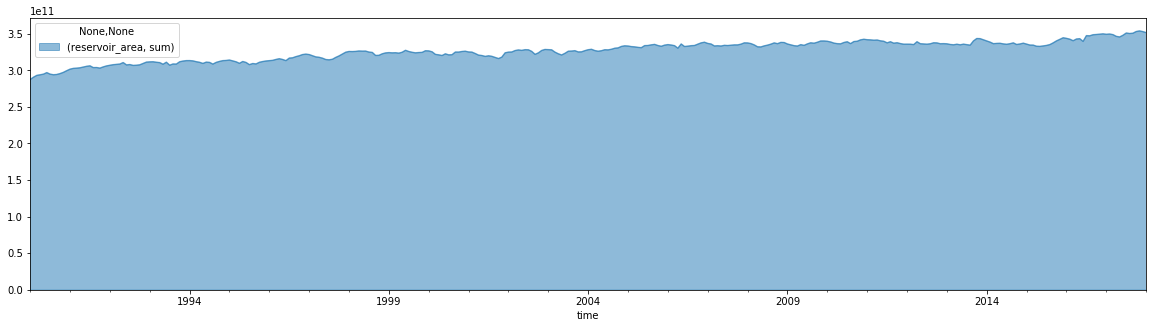

In [77]:
fig, ax = plt.subplots(figsize=(20, 5))
df[['time', 'reservoir_area']].groupby('time').agg(['sum']).plot(ax=ax, kind='area', alpha=0.5)

date_start = '1990-01-01'
date_stop = '2018-01-01'
ax.set_xlim([dateutil.parser.parse(date_start), dateutil.parser.parse(date_stop)])


In [95]:
df.head()

,basin_id,country_code,reservoir_area_max,time,reservoir_area
0,1001,US,10,1985-01-31,179288
1,1001,US,10,1985-02-28,171519
2,1001,US,10,1985-03-31,388898
3,1001,US,10,1985-04-30,1092151
4,1001,US,10,1985-05-31,1127930


reservoir_area_max
10            [10]
25            [25]
50            [50]
100          [100]
250          [250]
500          [500]
5000        [5000]
500000    [500000]
Name: reservoir_area_max, dtype: object

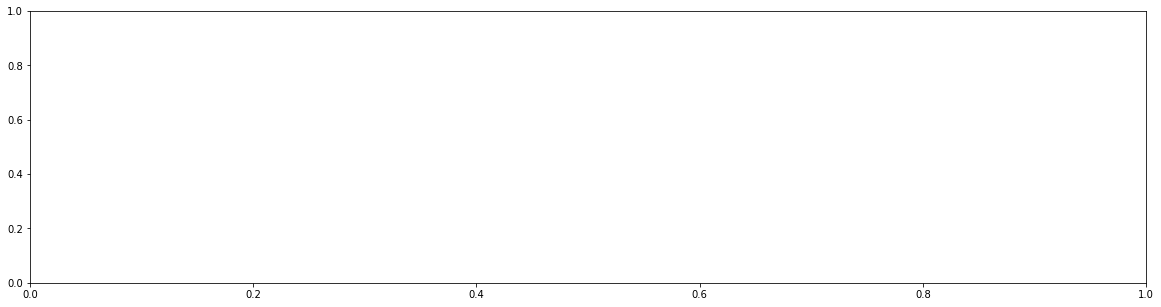

In [104]:
fig, ax = plt.subplots(figsize=(20, 5))
df_agg = df[['time', 'reservoir_area_max', 'reservoir_area']] \
    .groupby(['reservoir_area_max'])
#     .agg('sum')

# df_agg.head()

df_agg.reservoir_area_max.unique()


In [99]:
df_agg.pivot(columns='reservoir_area_max', values='reservoir_area').plot()

KeyError: 'reservoir_area_max'

In [92]:
df_agg.head()

reservoir_area
                                         sum
reservoir_area_max time                     
10                 1985-01-31         230280
                   1985-02-28         330200
                   1985-03-31        2364885
                   1985-04-30        6703747
                   1985-05-31       10637657

In [62]:
len(df.index)

1164934

In [1]:
import ee

ee.Initialize()

In [18]:
# Folium setup.
import folium
print(folium.__version__)

0.10.0


In [26]:
def map_add_ee_layer(map, image, name):
    tile_url = image.getMapId()['tile_fetcher'].url_format
    layer = folium.TileLayer(tiles=tile_url, attr='Google Earth Engine', overlay=True, name=name)
    layer.add_to(map)

In [48]:
map = folium.Map(location=[30, 10], zoom_start=2)

map_add_ee_layer(map, ee.Image(1).visualize(**{ 'palette': ['000000'], 'opacity': 0.5 }), 'black')

reservoirs_points = ee.FeatureCollection('users/gena/eo-reservoirs/waterbodies-points-reservoirs') \
    .style(**{ 'pointSize': 1, 'width': 0, 'color': '00ffff', 'fillColor': '00ffff33'})
map_add_ee_layer(map, reservoirs_points, 'reservoirs (points)')

# aggregation_areas = ee.FeatureCollection('users/gena/eo-reservoirs/waterbodies-points-reservoirs') \
#     .style(**{ 'pointSize': 1, 'width': 0, 'color': '00ffff', 'fillColor': '00ffff33'})
# map_add_ee_layer(map, reservoirs_points, 'reservoirs (points)')

map.add_child(folium.LayerControl())
map

In [6]:
print(reservoirs_points.getMapId())

{'mapid': 'projects/earthengine-legacy/maps/96cb6ed91eb91fb12df2c8c827b3c4e4-797704481b49b47074084c8fd1d8222c', 'token': '', 'tile_fetcher': <ee.data.TileFetcher object at 0x0000020F2CDAB748>, 'image': <ee.image.Image object at 0x0000020F2EDFAF60>}
